# Sequencing of Ensemble Solutions
This notebook uses The Sequencer to analyze the ensembles produced by our 1D electrical resistivity inversions.
1. Loading the output from MATLAB

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sequencer
from scipy.io import loadmat
import h5py

In [13]:
# define the files for each model run
n_keep = 1000 # 12500
offset = 0 # number that gets added to all log-rho values because EMD cannot deal with negative numbers

date = "02262024"



#analysis_file_base = "../Ensembles_Constable1984_1_11082023/Analysis_Constable1984_"
#ensemble_file_base = "../Ensembles_Constable1984_1_11082023/Ensemble_Constable1984_"

#analysis_file_base = "../Ensembles_Constable_MalinvernoPrior/Analysis_Constable1984_"
#ensemble_file_base = "../Ensembles_Constable_MalinvernoPrior/Ensemble_Constable1984_"

#analysis_file_base = "../Ensemble_Constable_nohierarchical_small/Analysis_Constable1984_nohierarchical_"
#ensemble_file_base = "../Ensemble_Constable_nohierarchical_small/Ensemble_Constable1984_nohierarchical_"

#analysis_file_base = "../Ensembles_Constable_11202023/Analysis_Constable1984_Wauchope__hierarchical-1_rhoPrior-2_"
#ensemble_file_base = "../Ensembles_Constable_11202023/Ensemble_Constable1984_Wauchope__hierarchical-1_rhoPrior-2_"

# analysis_file_base = "../Ensembles_Constable_12182023/Analysis_Constable1984__hierarchical-1_rhoPrior-2_"
# ensemble_file_base = "../Ensembles_Constable_12182023/Ensemble_Constable1984__hierarchical-1_rhoPrior-2_"

analysis_file_base = "../Ensembles_01202024/Analysis_Constable1984__hierarchical-1_rhoPrior-2_"
ensemble_file_base = "../Ensembles_01202024/Ensemble_Constable1984__hierarchical-1_rhoPrior-2_"

analysis_file_base = "../Ensembles_Rener_02222024/Analysis_Constable1984_Renner__hierarchical-1_rhoPrior-2_1_22-Feb-2024"
ensemble_file_base = "../Ensembles_Rener_02222024/Ensemble_Constable1984_Renner__hierarchical-1_rhoPrior-2_1_22-Feb-2024"
    
    
    
def load_analysis(filename):
    with h5py.File(filename, 'r') as file:
        print(list(file.keys()))
        log_rho = np.array(file["logRhoPlot"]) # logarithm of resistivity
        xVals = np.array(file["xVals"]) # log-resistivity bins used in analyses
        zVals = np.array(file["zVals"]) # logarithm of depth
        residuals = np.array(file["residuals"])
        ewre2n = np.array(file["ewre2n"])
    return xVals, zVals, log_rho, residuals, ewre2n
              
def load_ensemble(filename):
    with h5py.File(filename, 'r') as file:        
        depth = np.array(file["results"]["ensembleDepths"])
        rho = np.array(file["results"]["ensembleRhos"])
        n_layer = np.array(file["results"]["ensembleNumLayers"])
    return depth, rho, n_layer
            
# x, z, log_rho,residuals,ewre2n = load_analysis(analysis_file)
# depth, rho, n_layer = load_ensemble(ensemble_file)

In [ ]:
# Note - doing pcolor for all of logrhoplot is very very slow. That's why the code is commented out!
# plt.figure()
# plt.pcolor(log_rho)
# plt.colorbar()
# plt.show()

TypeError: 'function' object is not subscriptable

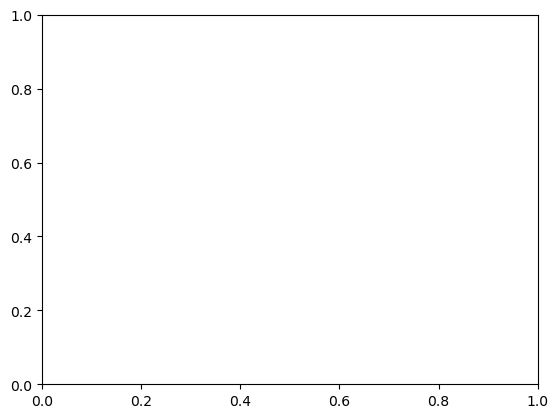

In [10]:
fig,ax = plt.subplots(1,1)
h = ax.pcolorfast(log_rho_samples.T,cmap=plt.colormaps['jet'])
plt.colorbar(h)
fig.show()

In [3]:
# noise_levels = ["0.01","0.02","0.05","0.1","0.2"]
noise_levels = ["1"]
all_keep_idx = []
import os
try:
    os.mkdir(date)
except:
    pass

# Sequence the log_rho samples and SAVE THE RESULTS FOR LATER USE!!
for noise_level in noise_levels:
    #     analysis_file = "../Ensembles_09132021/Analysis3LayerA_" + noise_level + ".mat"
    #     ensemble_file = "../Ensembles_09132021/Ensemble_3LayerA_" + noise_level + ".mat"
    analysis_file = analysis_file_base + ".mat"
    ensemble_file = ensemble_file_base + ".mat"
    # load the ensemble:
    print("now on ensemble "+ensemble_file)
    x, z, log_rho, residuals ,ewre2n = load_analysis(analysis_file)
    depth, rho, n_layer = load_ensemble(ensemble_file)
    
    # select a subset of the ensemble:
    #keep_idx = np.random.permutation(log_rho.shape[0])[:n_keep]
    keep_idx = np.arange(0,log_rho.shape[0],int(log_rho.shape[0]/n_keep))
    all_keep_idx.append(keep_idx) # save the keep idx for later use
    log_rho_samples = log_rho[keep_idx,:]
    
    offset = np.min(log_rho_samples)-1
    print("offset=",offset)
    
    assert( np.all(log_rho_samples - offset > 0) )
    
    estimator_list = ['EMD','L2','energy','KL']
    output_directory = date + "/sequencer_output_" + noise_level
    scale_list = [[1,2,5,10,20],[1,2,5,10,20],[1,2,5,10,20],[1,2,5,10,20]]
    import os
    try:
        os.mkdir(output_directory)
    except:
        pass
    seq = sequencer.Sequencer(z.flatten(), log_rho_samples - offset, estimator_list,scale_list=scale_list)
    final_elongation, final_sequence = seq.execute(output_directory,                                              
                                                  to_use_parallelization=True,
                                                  to_average_N_best_estimators=True, 
                                                  number_of_best_estimators=2)
np.save(date + "/keep_indices.npy",all_keep_idx)

now on ensemble ../Ensemble_Constable1984_Renner__hierarchical-1_rhoPrior-2_1_22-Feb-2024.mat
['#refs#', '#subsystem#', 'allClusterSets', 'allModels', 'allPartitions', 'binCenters', 'ewre2n', 'logRhoPlot', 'nRhoBins', 'numElements', 'nzplot', 'residuals', 'xVals', 'yVals', 'zVals']
offset= -1.7429030552222327
Parallelization is ON. Number of cores: 40
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 33.30716872215271 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 87.8218731880188 seconds
calculating the distance matrices for estimator: EMD, scale: 5
finished calculating this distance matrix list, it took: 353.61063146591187 seconds
calculating the distance matrices for estimator: EMD, scale: 10
finished calculating this distance matrix list, it took: 582.1486542224884 seconds
calculating the distance matrices for estimator: EMD, scale: 

/home/max/miniconda3/lib/python3.7/site-packages/sequencer/sequencer_.py:1025: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='02262024/sequencer_output_1/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='02262024/sequencer_output_1/final_products.pkl'>


In [28]:
# LOAD THE RESULTS AND PLOT! 
import matplotlib as mpl
all_keep_idx = np.load(date + "/keep_indices.npy")
noise_levels = ["1"]

for noise_level,keep_idx in zip(noise_levels,all_keep_idx):
    analysis_file = analysis_file_base + ".mat"
    ensemble_file = ensemble_file_base + ".mat"
    #analysis_file = "../Ensembles_09132021/Analysis3LayerA_" + noise_level + ".mat"
    #ensemble_file = "../Ensembles_09132021/Ensemble_3LayerA_" + noise_level + ".mat"
    # load the ensemble:
    print("now on ensemble "+ensemble_file)
    x, z, log_rho, residuals ,ewre2n = load_analysis(analysis_file)
    depth, rho, n_layer = load_ensemble(ensemble_file)
            
    # select a subset of the ensemble:
    log_rho_samples = log_rho[keep_idx,:]

    offset = np.min(log_rho_samples)-1
    print("offset=",offset)
    
    estimator_list = ['L2','EMD','energy','KL']
    output_directory = date + "/sequencer_output_" + noise_level
    scale_list = [[1,2,5,10,20],[1,2,5,10,20],[1,2,5,10,20],[1,2,5,10,20]]


    seq = sequencer.Sequencer(z.flatten(), log_rho_samples - offset, estimator_list,scale_list=scale_list)
    final_elongation, final_sequence = seq.execute(output_directory,                                              
                                                  to_average_N_best_estimators=True, 
                                                  number_of_best_estimators=2,
                                                  to_calculate_distance_matrices=False,
                                                  to_save_distance_matrices=False,
                                                  distance_matrices_inpath=output_directory + "/distance_matrices.pkl")
    
    print("intermediate elongations for the different metrics and scales:")
    estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
    for i in range(len(estimator_list)):
        print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                       scale_list[i], 
                                                       elongation_list[i]))
        
    # PLOTTING!!
    xlabel = np.arange(n_keep)
    zlabel = (z[0][0:-1]+z[0][1:])/2.0

    vmin = np.min(log_rho_samples)
    vmax = np.max(log_rho_samples)
#     vmin = -1
    #vmax = 6
    cmap = mpl.colors.Colormaps('inferno')

    import matplotlib.gridspec as gridspec
    estimator_list, scale_list, sequence_list = seq.return_sequence_of_weighted_products_all_metrics_and_scales()
    
    nscale=5;
    for i in range(nscale):
        # fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(16,4))
        fig = plt.figure(constrained_layout=True,figsize=(12,4))
        spec = gridspec.GridSpec(ncols=5, nrows=2, figure=fig)
        ax0 = fig.add_subplot(spec[0, 0])
        ax1 = fig.add_subplot(spec[0, 1])
        ax2 = fig.add_subplot(spec[0, 2])
        ax3 = fig.add_subplot(spec[0, 3])
        ax4 = fig.add_subplot(spec[0, 4])

        # sequence = final_sequence
        ax0.pcolormesh(xlabel,z[0],log_rho_samples.T,vmin=vmin,vmax=vmax,rasterized=True)
        ax0.set_title("Unordered Ensemble")
        ax0.set_yscale("log")
        ax0.invert_yaxis()
        ax0.set_ylabel("Depth (m)")

        pcm = ax1.pcolormesh(xlabel,z[0],log_rho_samples[sequence_list[nscale*0+i],:].T,vmin=vmin,vmax=vmax,rasterized=True)
        ax1.set_title(estimator_list[nscale*0+i])
        ax1.set_yscale("log")
        ax1.invert_yaxis()

        ax2.pcolormesh(xlabel,z[0],log_rho_samples[sequence_list[nscale*1+i],:].T,vmin=vmin,vmax=vmax,rasterized=True)
        ax2.set_title(estimator_list[nscale*1+i])
        ax2.set_yscale("log")
        ax2.invert_yaxis()

        ax3.pcolormesh(xlabel,z[0],log_rho_samples[sequence_list[nscale*2+i],:].T,vmin=vmin,vmax=vmax,rasterized=True)
        ax3.set_title(estimator_list[nscale*2+i])
        ax3.set_yscale("log")
        ax3.invert_yaxis()

        ax4.pcolormesh(xlabel,z[0],log_rho_samples[sequence_list[nscale*3+i],:].T,vmin=vmin,vmax=vmax,rasterized=True)
        ax4.set_title(estimator_list[nscale*3+i])
        ax4.set_yscale("log")
        ax4.invert_yaxis()

        fig.colorbar(pcm,ax=ax4,shrink=0.8)
        plt.savefig(date + "/figure_ensemble_" + noise_level + "{:d}.pdf".format(i),dpi=300)
        fig.show()

now on ensemble ../Ensembles_Rener_02222024/Ensemble_Constable1984_Renner__hierarchical-1_rhoPrior-2_1_22-Feb-2024.mat
['#refs#', '#subsystem#', 'allClusterSets', 'allModels', 'allPartitions', 'binCenters', 'ewre2n', 'logRhoPlot', 'nRhoBins', 'numElements', 'nzplot', 'residuals', 'xVals', 'yVals', 'zVals']
offset= -1.7429030552222327
strating to sequence the different scales and estimators
in estimator: L2, scale: 1
in estimator: L2, scale: 2
in estimator: L2, scale: 5
in estimator: L2, scale: 10
in estimator: L2, scale: 20
in estimator: EMD, scale: 1
in estimator: EMD, scale: 2
in estimator: EMD, scale: 5
in estimator: EMD, scale: 10
in estimator: EMD, scale: 20
in estimator: energy, scale: 1
in estimator: energy, scale: 2
in estimator: energy, scale: 5
in estimator: energy, scale: 10
in estimator: energy, scale: 20
in estimator: KL, scale: 1
in estimator: KL, scale: 2
in estimator: KL, scale: 5
in estimator: KL, scale: 10
in estimator: KL, scale: 20
dumped the elongations to the file

/home/max/miniconda3/lib/python3.7/site-packages/sequencer/sequencer_.py:1025: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='02262024/sequencer_output_1/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='02262024/sequencer_output_1/final_products.pkl'>
intermediate elongations for the different metrics and scales:
metric=L2, scale=1, elongation: 4.359096
metric=L2, scale=2, elongation: 3.929024
metric=L2, scale=5, elongation: 3.189318
metric=L2, scale=10, elongation: 3.821126
metric=L2, scale=20, elongation: 4.913919999999999
metric=EMD, scale=1, elongation: 48.084988
metric=EMD, scale=2, elongation: 45.282054
metric=EMD, scale=5, elongation: 46.866496000000005
metric=EMD, scale=10, elongation: 27.759750000000004
metric=EMD, scale=20, elongation: 14.760999999999997
metric=energy, scale=1, elongation: 16.500394
metric=energy, scale=2, elongation: 10.4095
metric=energy, scale=5, elongation: 17.612900000000003
metric=energy, scale=10, elongation: 9.8827
metric=energy, scale=20, elo

AttributeError: module 'matplotlib.colors' has no attribute 'Colormaps'

In [ ]:
ewre_keep = ewre2n[keep_idx]
residual_keep = residuals[keep_idx,:]
print(residuals.shape)

plt.figure()
plt.plot(residual_keep[sequence_list[1]])
plt.show()

In [ ]:
estimator_list
scale_list
# sequence_list

In [ ]:
keep_idx

In [27]:
mpl.colors.Colormap('viridis')


In [ ]:
plt.hist(log_rho_samples[:,999].ravel())

In [ ]:
log_rho_samples.shape

In [ ]:
test = np.arange(0,log_rho.shape[0],int(log_rho.shape[0]/n_keep))
test.shape

In [ ]:
keep_idx.shape

In [ ]:
test.dtype